In [2]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from collections import Counter

from sklearn import preprocessing as sk_preprocessing
import re
from tensorflow.keras import preprocessing as t_preprocessing
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


matplotlib.style.use('ggplot')

This notebook demonstrates a step-by-step approach to train a deep learning model for Natural Language Processing. In this guide, we will use a sms spam dataset, prepare the data using native Python tools and train the model using Keras Sequential API. It is worth noting, that the steps for preprocessing can be achieved more quickly using ready-made tools provided by Keras, however, the intention was to build everytrhing frokm scratch. Ready-made tools will be used in next experiments (data_analysis_and_experimenting.ipynb).

Let's first load the sms dataset

In [4]:
sms_data_path = r'datasets/sms-spam-collection/spam.csv'
sms_df = pd.read_csv(sms_data_path, engine='python')
sms_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


We see that the dataset has some redundant columns. Generally, we are interested in columns v1 and v2. V1 will be our target value, and v1 will be our input data. Let's take them out.

In [5]:
x, y = sms_df['v2'].values, sms_df['v1'].values

Let's print out some examplary message

In [12]:
print(x[10])

I&#39;m gonna be home soon and i don&#39;t want to talk about this stuff anymore tonight, k? I&#39;ve cried enough today.


Looks as a legit message to me. Let's check out the label for that message

In [13]:
print(y[10])

ham


Yup, that's not a spam

Let's print out the longest message in the dataset

In [14]:
sms_lengths = list(map(lambda x: len(x), x))
# Longest sms message
print(x[np.argmax(sms_lengths)])

For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don&#39;t have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..


Okay, let's move on. We will start by mapping the text to the encoding. The strategy is to get all the words, that are occuring in the messages, and map them to a unique integer value. This way, the message will be represented as an array of integer numbers. We will use regex expression to split all the message into words.

In [21]:
word_regex = r"[\w']+"
all_words = [word.lower() for sms in x for word in re.findall(word_regex,sms)]

We will use Counter from collections library that generates a dictionary from a Collection of items. The key is an item and a value is a number of occurences of the item in a Collection

In [25]:
word_count = Counter(all_words)
word_count_sorted = word_count.most_common()

num_words = len(word_count_sorted)

print(f"We have {num_words} words in our messages")

We have 8910 words in our messages


Text(0, 0.5, &#39;Number of words with such occurence&#39;)

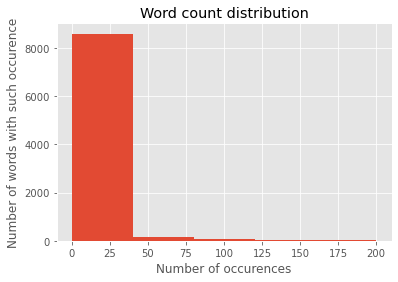

In [29]:
plt.hist(word_count.values(), bins=5, range=(0, 200))
plt.title('Word count distribution')
plt.xlabel('Number of occurences')
plt.ylabel('Number of words with such occurence')

Majority of words occur up to 50 times in the whole dataset.

Let us take 7999 most common words from the text. We reserve 8000th token for the rest of the words which occurred but do not have an integer mapping

In [30]:
word_count_sorted = word_count_sorted[:7998]

We will generate two dictionaries: one that will enable us to encode words, and the other one for decoding numbers into words. The values are being assigned from the most common word to least common word. A 'missing_word' key is a special one for words that do not have coding

In [31]:
word_encoding = { word_count_pair[0]: i for i, word_count_pair in enumerate(word_count_sorted, start=1) }
word_decoding = dict(zip(word_encoding.values(), word_encoding.keys()))

missing_word_code = max(word_encoding.values())+1
word_encoding['missing_word'] = missing_word_code
word_decoding[missing_word_code] = 'missing_word'

Below is a function that will encode an entire dataset.

In [42]:
# encode dataset

def encode_dataset(data, word_encoding):
    data_encoded = []

    for sms in data:
        sms_words = re.findall(r"[\w']+", sms)
        sms_encoded = [word_encoding[word] if word in word_encoding.keys() else missing_word_code for word in sms_words]
        data_encoded.append(sms_encoded)
    
    return data_encoded

Let's do that and check first message

In [43]:
x_encoded = encode_dataset(x, word_encoding)
x_encoded[1]

[7999, 336, 7999, 471, 6, 1929]

For convenience, let's create fuinctions for encoding and decoding a single message. We will use assertion to verify, that the operation is reversible

In [45]:
def encode_sms(decoded_sms, word_encoding):
    encoded_sms = [word_encoding[word] if word in decoded_sms else word_encoding['missing_word'] for word in decoded_sms]
    return encoded_sms

def decode_sms(encoded_sms, word_decoding):
    decoded_sms = [word_decoding[code] for code in encoded_sms]
    return decoded_sms

assert x_encoded[0] == encode_sms(decode_sms(x_encoded[0], word_decoding), word_encoding), "Codes do not match!"

No errors, no worries!

Now, the main part. Our main goal is to train a deep learning model. As we know, deep learning model needs to have a fixed-length input data. Our messages have different lengths - some are short, some are long. We need to define a size for each message, and we will call it MAX_LEN. Basically, the messages containing more than 100 words will be truncated, and shorter messages will be padded with placeholder tokens. Let's define a MAX_LEN size of 100 and use tensorflow's convieniet function pad_sequences

In [49]:
MAX_LEN = 100

x_encoded_padded = t_preprocessing.sequence.pad_sequences(x_encoded, MAX_LEN)

x_encoded_padded = np.array(x_encoded_padded)

print(x_encoded_padded.shape)

(5572, 100)


Now we have 5572 messages, each of size 100

There is only ony thing left. Let's recall what are our targets

In [53]:
print(np.unique(y))

[&#39;ham&#39; &#39;spam&#39;]


We can't feed the network with string data. We need to code these classes to numerical values, and we can achieve it with sklearn's LabelEncoder class

In [54]:
label_encoder = sk_preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(y)

In [55]:
label_encoder.classes_

array([&#39;ham&#39;, &#39;spam&#39;], dtype=object)

In [57]:
np.unique(labels)

array([0, 1])

Let's split the data into train and test

In [58]:
X_train, X_test, y_train, y_test = train_test_split(x_encoded_padded, labels, stratify=labels, test_size=0.2, random_state=1)

Let's define a model. The model is quite simple, we start from Embedding layer, which will try to find correlations between different words and create a dimensional representation to make word dependencies easier to spot.
Remember, we take only 8000 words, so in Embedding layer will have dimensionality of 8000.

Next, we will define an LSTM layer. This layer is more complicated than SimpleRNN, but it does a better job in findning long-term dependencies in sequences. Well, sms are quite short, but we can do with added computational complexity and a bit more params in a network

On top of that, we will use a Fully Connected layer, and add a Dropout to reduce overfitting.

In [62]:
NUM_WORDS = 8000

In [65]:
def simple_lstm_model(num_words=NUM_WORDS, max_len=MAX_LEN):
    model = Sequential()
    model.add(layers.Embedding(num_words, 16, input_length=max_len))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [66]:
model = simple_lstm_model()
model.summary()

Model: &quot;sequential_1&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           128000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 256)               8448      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 142,977
Trainable params: 142,977
Non-trainable params: 0
_________________________________________________________________


Let's train this network!

In [67]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
112/112 [==============================] - 1s 11ms/step - loss: 0.2641 - accuracy: 0.8979 - val_loss: 0.1004 - val_accuracy: 0.9574
Epoch 2/10
112/112 [==============================] - 1s 7ms/step - loss: 0.1094 - accuracy: 0.9630 - val_loss: 0.0607 - val_accuracy: 0.9776
Epoch 3/10
112/112 [==============================] - 1s 7ms/step - loss: 0.0552 - accuracy: 0.9851 - val_loss: 0.0534 - val_accuracy: 0.9821
Epoch 4/10
112/112 [==============================] - 1s 7ms/step - loss: 0.0402 - accuracy: 0.9877 - val_loss: 0.0523 - val_accuracy: 0.9843
Epoch 5/10
112/112 [==============================] - 1s 7ms/step - loss: 0.0311 - accuracy: 0.9910 - val_loss: 0.0703 - val_accuracy: 0.9787
Epoch 6/10
112/112 [==============================] - 1s 8ms/step - loss: 0.0248 - accuracy: 0.9927 - val_loss: 0.1265 - val_accuracy: 0.9619
Epoch 7/10
112/112 [==============================] - 1s 7ms/step - loss: 0.0215 - accuracy: 0.9933 - val_loss: 0.0738 - val_accuracy: 0.9843
Epoch

The task seemed quite easy for a network. Let's make sure it is indeed easy on a test set, as sometimes the network can overfit to train as well as val set.

In [68]:
model.evaluate(X_test, y_test)

35/35 [==============================] - 0s 4ms/step - loss: 0.0871 - accuracy: 0.9767


[0.08709598332643509, 0.9766815900802612]

Seems like our network is great! But is it? It does a good job in recognizing sms messages, but is it that great for e-mails as well?

In [69]:
mail_spam_csv = pd.read_csv(r'datasets\mail-spam-collection\spam_ham_dataset.csv')

In [92]:
mail_spam_csv.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [93]:
x_spam, y_spam = mail_spam_csv['text'].values, mail_spam_csv['label_num'].values

In [94]:
x_spam.shape

(5171,)

In [95]:
y_spam.shape

(5171,)

In [161]:
x_spam_encoded = list()

for mail in x_spam:
    mail_words = re.findall(r"[\w']+", mail)
    mail_encoded = [word_encoding[word] if word in word_encoding.keys() else missing_word_code for word in mail_words]
    x_spam_encoded.append(mail_encoded)

In [162]:
x_spam_padded = t_preprocessing.sequence.pad_sequences(x_spam_encoded, MAXLEN)

In [180]:
model.evaluate(x_spam_padded, y_spam)

162/162 [==============================] - 1s 4ms/step - loss: 2.6695 - accuracy: 0.6326


[2.66947078704834, 0.6325662136077881]

In [168]:
from collections import Counter

In [169]:
c = Counter(y_spam)

In [170]:
c

Counter({0: 3672, 1: 1499})

In [171]:
# we have data mismatch, let us again train the network on union of train sets

In [172]:
X_mail_train, X_mail_test, y_mail_train, y_mail_test = train_test_split(x_spam_padded, y_spam, stratify=y_spam, test_size=0.2, random_state=1)

In [184]:
Xtr, ytr = np.vstack([X_train, X_mail_train]), np.hstack([y_train, y_mail_train])
Xte, yte = np.vstack([X_test, X_mail_test]), np.hstack([y_test, y_mail_test])

In [185]:
model2 = simple_lstm_model()
model2.summary()

Model: &quot;sequential_13&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 16)           128000    
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_26 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 257       
Total params: 142,977
Trainable params: 142,977
Non-trainable params: 0
_________________________________________________________________


In [186]:
neg, pos = np.bincount(y_mail_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

Examples:
    Total: 4136
    Positive: 1199 (28.99% of total)



In [187]:
X_mail_train[98]

array([7999, 7816, 7999, 7999, 7455, 3731, 7999, 7870, 7999, 7999, 7999,
       7999, 3845, 3566, 7999, 3619, 7999, 7999, 7999, 7999, 7999, 7999,
       4689, 5137, 7999, 7999, 7999, 7999, 7999, 7999, 7999, 7999, 7999,
       7999, 7999, 7999, 7999, 7999, 7999, 7999, 7999,   51, 7999, 7878,
       7999, 3546, 7999, 7999, 7999, 1320, 7999, 7999, 7999, 1229, 2657,
        894,    8, 7999,    8, 7999,   36, 7999, 7999, 7999,  799,  187,
        299,  935, 7999, 5382, 4689, 5137, 7999, 7999, 5646, 7999, 7999,
        799,  187, 7999,    2, 2841,  883,    5, 4689, 7999, 7999, 7999,
       1229,    5, 1229, 7999, 3719,   12, 7999, 7999, 7999,  507,   51,
       7455])

In [188]:
history = model2.fit(X_mail_train, y_mail_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight)

Epoch 1/10
104/104 [==============================] - 1s 10ms/step - loss: 0.4281 - accuracy: 0.7869 - val_loss: 0.1704 - val_accuracy: 0.9384
Epoch 2/10
104/104 [==============================] - 1s 7ms/step - loss: 0.1446 - accuracy: 0.9423 - val_loss: 0.1073 - val_accuracy: 0.9638
Epoch 3/10
104/104 [==============================] - 1s 8ms/step - loss: 0.0875 - accuracy: 0.9674 - val_loss: 0.0823 - val_accuracy: 0.9662
Epoch 4/10
104/104 [==============================] - 1s 8ms/step - loss: 0.0652 - accuracy: 0.9770 - val_loss: 0.0941 - val_accuracy: 0.9674
Epoch 5/10
104/104 [==============================] - 1s 8ms/step - loss: 0.0466 - accuracy: 0.9837 - val_loss: 0.0952 - val_accuracy: 0.9674
Epoch 6/10
104/104 [==============================] - 1s 7ms/step - loss: 0.0383 - accuracy: 0.9879 - val_loss: 0.1170 - val_accuracy: 0.9601
Epoch 7/10
104/104 [==============================] - 1s 7ms/step - loss: 0.0216 - accuracy: 0.9924 - val_loss: 0.1332 - val_accuracy: 0.9722
Epoch

In [189]:
model2.evaluate(X_mail_test, y_mail_test)

33/33 [==============================] - 0s 4ms/step - loss: 0.2065 - accuracy: 0.9739


[0.20649106800556183, 0.9739130139350891]

In [190]:
model3 = simple_lstm_model()
model3.summary()

Model: &quot;sequential_14&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 16)           128000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_28 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 142,977
Trainable params: 142,977
Non-trainable params: 0
_________________________________________________________________


In [191]:
history = model3.fit(Xtr, ytr, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
215/215 [==============================] - 2s 9ms/step - loss: 0.2972 - accuracy: 0.8819 - val_loss: 0.3020 - val_accuracy: 0.8802
Epoch 2/10
215/215 [==============================] - 2s 7ms/step - loss: 0.1534 - accuracy: 0.9475 - val_loss: 0.2505 - val_accuracy: 0.9069
Epoch 3/10
215/215 [==============================] - 2s 7ms/step - loss: 0.1153 - accuracy: 0.9601 - val_loss: 0.2741 - val_accuracy: 0.9116
Epoch 4/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0926 - accuracy: 0.9699 - val_loss: 0.2749 - val_accuracy: 0.9168
Epoch 5/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0825 - accuracy: 0.9713 - val_loss: 0.2668 - val_accuracy: 0.9122
Epoch 6/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0728 - accuracy: 0.9757 - val_loss: 0.2413 - val_accuracy: 0.9191
Epoch 7/10
215/215 [==============================] - 2s 7ms/step - loss: 0.0668 - accuracy: 0.9785 - val_loss: 0.2297 - val_accuracy: 0.9232
Epoch 

In [192]:
model3.evaluate(Xte, yte)

68/68 [==============================] - 0s 3ms/step - loss: 0.1947 - accuracy: 0.9456


[0.19468116760253906, 0.9455813765525818]

In [112]:
X_train.shape

(4457, 100)

In [108]:
X_mail_train.shape

(4136, 100)

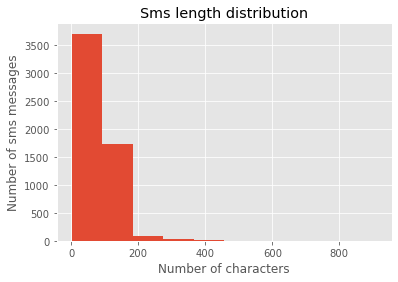

In [41]:
plt.hist(sms_lengths, bins=10)
plt.title('Sms length distribution')
plt.ylabel('Number of sms messages')
plt.xlabel('Number of characters')
plt.show()
